In [5]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import measuring2 as mrs
import load_and_graph2 as lg
import community as cm
%matplotlib inline

In [6]:
edges = pd.read_csv('/Users/rdelapp/Galvanize/DSI_g61/capstone/panama_papers/data/csv_panama_papers_2018-02-14/panama_papers_edges.csv')
edges = edges[edges["TYPE"] != "registrated address"]
F = nx.from_pandas_dataframe(edges, "START_ID", "END_ID") # Return a graph from Pandas DataFrame.

#

# Read node lists
officers       = pd.read_csv('/Users/rdelapp/Galvanize/DSI_g61/capstone/panama_papers/data/csv_panama_papers_2018-02-14/panama_papers_nodes_officer.csv', index_col = "node_id")
intermediaries = pd.read_csv('/Users/rdelapp/Galvanize/DSI_g61/capstone/panama_papers/data/csv_panama_papers_2018-02-14/panama_papers_nodes_intermediary.csv', index_col = "node_id")
entities       = pd.read_csv('/Users/rdelapp/Galvanize/DSI_g61/capstone/panama_papers/data/csv_panama_papers_2018-02-14/panama_papers_nodes_entity.csv', index_col = "node_id")
addresses      = pd.read_csv('/Users/rdelapp/Galvanize/DSI_g61/capstone/panama_papers/data/csv_panama_papers_2018-02-14/panama_papers_nodes_address.csv', index_col = "node_id")

/Applications/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Applications/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
G, all_nodes = lg.load_clean_data()
ego = lg.build_subgraph(G, all_nodes)

/Applications/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/Applications/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [7]:
partition = cm.best_partition(ego) # Louvian

In [13]:
type(partition.values())

dict_values

In [10]:
from collections import default dict
for k,v in set(partition.values()):
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    ego2 = nx.subgraph(ego, list_nodes)

IndexError: list assignment index out of range

In [38]:
# edges.head(10)

In [8]:
officers.columns


Index(['name', 'country_codes', 'countries', 'sourceID', 'valid_until',
       'note'],
      dtype='object')

In [9]:
intermediaries.columns


Index(['name', 'country_codes', 'countries', 'status', 'sourceID',
       'valid_until', 'note'],
      dtype='object')

In [10]:
entities.columns


Index(['name', 'jurisdiction', 'jurisdiction_description', 'country_codes',
       'countries', 'incorporation_date', 'inactivation_date',
       'struck_off_date', 'closed_date', 'ibcRUC', 'status', 'company_type',
       'service_provider', 'sourceID', 'valid_until', 'note'],
      dtype='object')

In [7]:
addresses.columns

Index(['name', 'address', 'country_codes', 'countries', 'sourceID',
       'valid_until', 'note'],
      dtype='object')

In [7]:
# Combine the node lists into one dataframe
officers["type"] = "officer"
intermediaries["type"] = "intermediary"
entities["type"] = "entity"
addresses["type"] = "address"

#Concatentate
all_nodes = pd.concat([officers, intermediaries, entities])

# Do some cleanup of names
all_nodes["name"] = all_nodes["name"].str.upper().str.replace(' ','_')

# Ensure that all "Bearers" do not become a single node
all_nodes["name"].replace(
    to_replace = [r"MRS?\.\s+", r"\.", r"\s+", "LIMITED", "THE BEARER", "BEARER", "BEARER 1", "EL PORTADOR", "AL PORTADOR"],
    value = ["","", "", "LTD", np.nan, np.nan, np.nan, np.nan, np.nan],
    inplace = True, regex = True)

In [28]:
# if "ISSUES OF:" in F:
#     F.remove_node("ISSUES OF:")

# if "" in F:
#     F.remove_node("")

In [8]:
CCODES = "SAU", "JOR"
#seeds = all_nodes[all_nodes["country_codes"] == 'SAU'].index
seeds = all_nodes[all_nodes["country_codes"].isin(CCODES)].index

# # Next Computes the shortest path from the node seed to all reachable nodes that
# # are cutoff hops away and closer.  The function returns a dictionary with the target nodes as keys,
# # so the keys are the cutoff-neighborhood of the seed.
nodes_of_interest = set.union(*[set(nx.single_source_shortest_path_length(F, seed, cutoff = 2).keys())
                               for seed in seeds])
# Extract the subgraph that contains all the keys for all the dictionaries
# with all the connecting eges ... and relabel it
ego = nx.subgraph(F, nodes_of_interest)
nodes = all_nodes.reindex(ego)
# nodes = all_nodes.ix[ego.nodes()]
nodes = nodes[~nodes.index.duplicated()] # There are duplicate countru codes on some nodes

#  Sets node attributes for nodes["country_codes"] from a given value or dictionary of values
nx.set_node_attributes(ego, nodes["country_codes"], "cc")
nx.set_node_attributes(ego, nodes["type"], "ty")
nx.set_node_attributes(ego, nodes["name"], "nm")
# get rid of null and turn the list into a dictionary
valid_names = nodes[nodes["name"].notnull()]["name"].to_dict()
ego = nx.relabel_nodes(ego, nodes[nodes.name.notnull()].name)
# ego = nx.relabel_nodes(ego, nodes[nodes.address.notnull()
#                                 & nodes.name.isnull()].address)
# nx.relabel_nodes(ego, valid_names)

In [10]:
seeds

Int64Index([12010787, 12015283, 12015284, 12036448, 12097807, 12098963,
            12098962, 12098655, 12098777, 12099127,
            ...
            10211490, 10211721, 10211969, 10212252, 10212316, 10213006,
            10213606, 10213755, 10214059, 10214315],
           dtype='int64', name='node_id', length=2820)

In [45]:
partitions = community.best_partition(ego)
type(partitions)

dict

In [20]:
# type(nodes[nodes.name.notnull()].name)

pandas.core.series.Series

In [35]:
# Must be negative: that's what OFFSHORES are about!
print("Country code assortativity:",
      nx.attribute_assortativity_coefficient(ego,'cc'))

Country code assortativity: nan


/Applications/anaconda/lib/python3.6/site-packages/networkx/algorithms/assortativity/correlation.py:264: RuntimeWarning: invalid value encountered in true_divide
  r=(t-s)/(1-s)


In [30]:
filename = "jupyter2"
with open ("/Users/rdelapp/Galvanize/DSI_g61/capstone/panama_papers/figures/panama-{y}.graphml".format(y=filename), "wb") as ofile:
    nx.write_graphml(ego, ofile)
pass

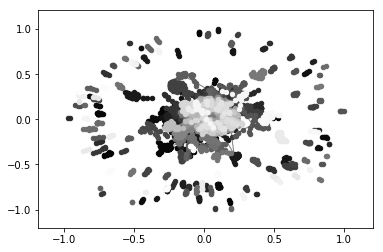

In [25]:
import community
G = ego.copy()

#first compute the best partition
partition = community.best_partition(G)

# draw
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(G, pos, alpha=0.5)

In [26]:
dgr = nx.degree_centrality(G)


In [43]:

all_nodes = pd.concat([officers, intermediaries, addresses, entities])
# 
# Do some cleanup of names
all_nodes['name'] = all_nodes['name'].str.upper()
all_nodes['name'] = all_nodes['name'].str.strip()

# Ensure that all "Bearers" do not become a single node
all_nodes['name'].replace(
    to_replace=[r'MRS?\.\s+', r'\.', r'\s+', 'LIMITED', 'THE BEARER'], 
    value=['', '', ' ', 'LTD', np.nan], 
    inplace=True, regex=True)

# The network is ready to use
# As an exercise, let's have a look at Mr.Roldugin's or Mr. Poroshenko's assets
seeds = [12079386, 12096275, 12180773] # Roldugin
# seeds = [12129717, 13001828] # Poroshenko
nodes_of_interest = set.union(*[set(nx.single_source_shortest_path_length(F, x, cutoff=4).keys()) for x in seeds])

# Extract the subgraph and relabel it
ego = nx.subgraph(F, nodes_of_interest)

nodes = all_nodes.reindex(ego)
nx.set_node_attributes(ego, nodes["country_codes"], "cc")
ego = nx.relabel_nodes(ego, nodes[nodes.name.notnull()].name)
ego = nx.relabel_nodes(ego, nodes[nodes.address.notnull() 
                                    & nodes.name.isnull()].address)

# # Must be negative: that's what OFFSHORES are about!
# print("Country code assortativity:",
#       nx.attribute_assortativity_coefficient(ego,'cc'))

# Save and proceed to Gephi
filename = "jupyter_Zinoviev"
with open ("/Users/rdelapp/Galvanize/DSI_g61/capstone/panama_papers/figures/panama-{y}.graphml".format(y=filename), "wb") as ofile:
    nx.write_graphml(ego, ofile)
pass